### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
import pyspark.sql
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BBBSBBBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
13047
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[80 4D 00 46 E0 5...|1931.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[00 4F 80 51 00 4...|1932.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     2|[20 D0 00 53 A0 5...|1933.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     2|[30 55 80 C9 A0 D...|1934.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     1|[E0 50 00 CF 00 5...|1935.0|BBBSBBBB|
+---------+--------+---------+-----------+-----------+------+-------------

In [8]:
print df.schema

StructType(List(StructField(elevation,DoubleType,true),StructField(latitude,DoubleType,true),StructField(longitude,DoubleType,true),StructField(measurement,StringType,true),StructField(station,StringType,true),StructField(undefs,LongType,true),StructField(vector,BinaryType,true),StructField(year,DoubleType,true),StructField(label,StringType,true)))


In [2]:
pdf=df.filter("measurement='TMAX' or measurement='TMIN'").toPandas()
Comb_pdf=pd.merge(pdf[pdf.measurement=='TMAX'],pdf[pdf.measurement=='TMIN'],on=['year','station'])
Comb_pdf.head(2)

,elevation_x,latitude_x,longitude_x,measurement_x,station,undefs_x,vector_x,year,label_x,elevation_y,latitude_y,longitude_y,measurement_y,undefs_y,vector_y,label_y
0,6.1,42.4667,-70.9,TMAX,USC00198301,0,"[128, 77, 0, 70, 224, 84, 224, 84, 160, 83, 32...",1931.0,BBBSBBBB,6.1,42.4667,-70.9,TMIN,0,"[128, 209, 224, 213, 64, 210, 128, 73, 64, 204...",BBBSBBBB
1,6.1,42.4667,-70.9,TMAX,USC00198301,0,"[0, 79, 128, 81, 0, 70, 128, 205, 0, 0, 160, 8...",1932.0,BBBSBBBB,6.1,42.4667,-70.9,TMIN,0,"[32, 208, 128, 201, 0, 207, 48, 213, 48, 213, ...",BBBSBBBB


In [9]:
row.keys()

Index([u'elevation_x', u'latitude_x', u'longitude_x', u'measurement_x',
       u'station', u'undefs_x', u'vector_x', u'year', u'label_x',
       u'elevation_y', u'latitude_y', u'longitude_y', u'measurement_y',
       u'undefs_y', u'vector_y', u'label_y'],
      dtype='object')

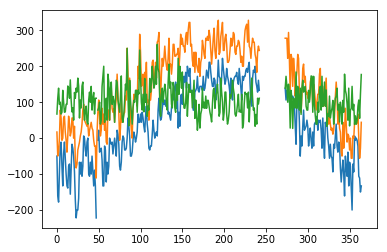

In [14]:
List=[]
for index,row in Comb_pdf.iterrows():
    #unpackArray(row['vector'],np.float16)

    _tmax = unpackArray(row['vector_x'],np.float16)
    _tmin = unpackArray(row['vector_y'],np.float16)
    _diff = _tmax-_tmin
    row['vector_diff']=packArray(_diff)
    item=[row[x] for x in [u'elevation_x', u'latitude_x', u'longitude_x', u'measurement_x',
       u'station', u'undefs_x', u'vector_diff', u'year', u'label_x']]
    List.append(item)
plot(_tmin)
plot(_tmax)
plot(_diff)

In [16]:
len(List),shape(pdf)

(2241, (4504, 9))

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00198301')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00198301'
26 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      6.1| 42.4667|    -70.9|       PRCP|USC00198301|     1|[00 00 00 00 00 0...|1931.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       PRCP|USC00198301|     4|[00 00 4C 61 20 5...|1932.0|BBBSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(26, 365)

### Script for plotting yearly plots

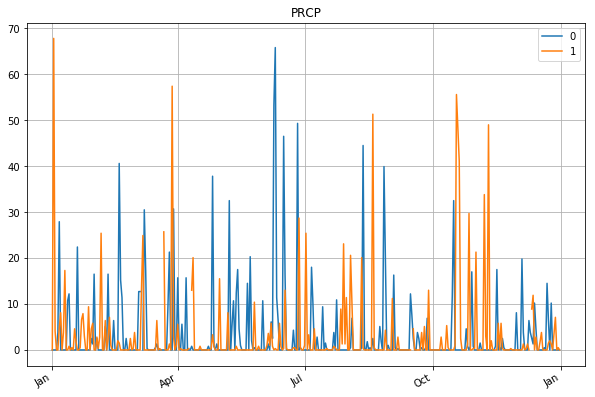

In [4]:
#from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP');
plt.savefig('percipitation.png')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [47]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)

def plot_single(element,func,filename):
    fig,axis=subplots(1,1,figsize=(8,6))
    func(element,fig,axis)
    fig.savefig(filename)
                
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

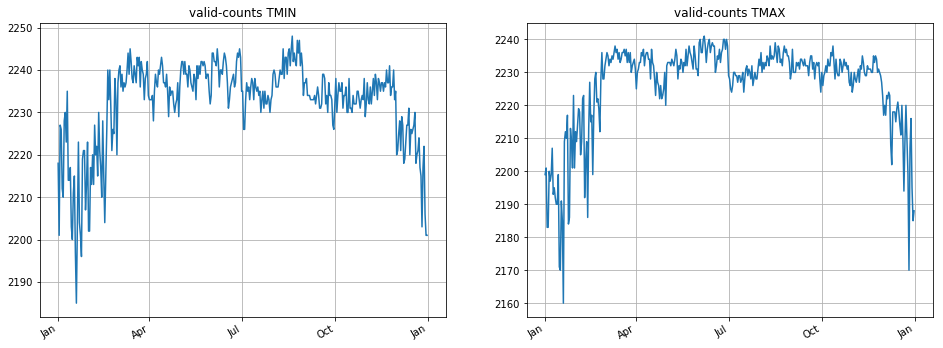

In [48]:
plot_pair(['TMIN','TMAX'],plot_valid)

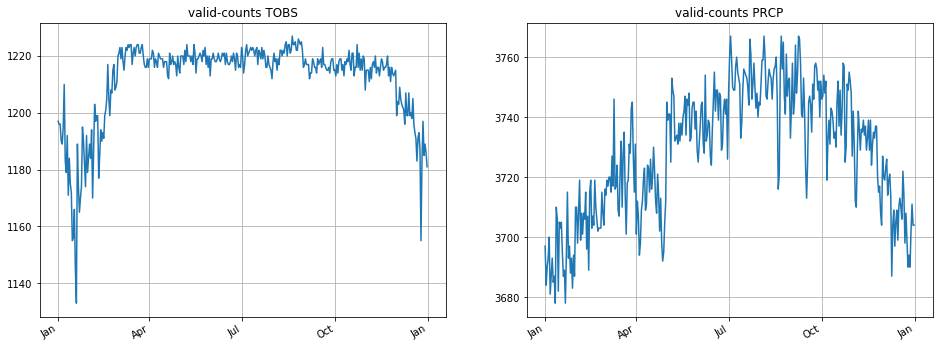

In [49]:
plot_pair(['TOBS','PRCP'],plot_valid)

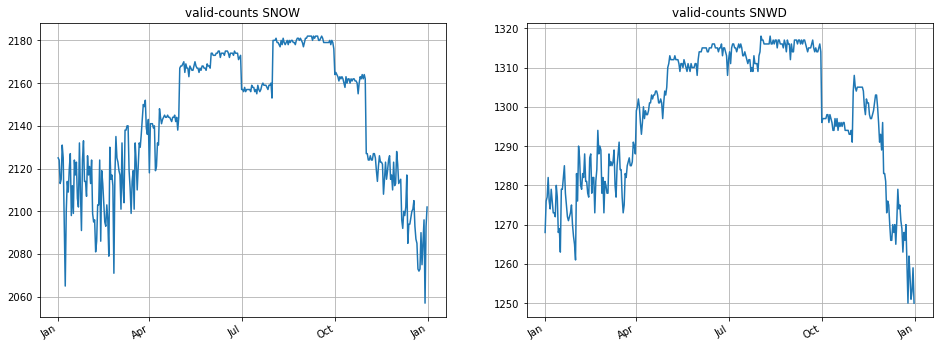

In [50]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [87]:
def plot_mean_std(m,fig,axis):
    scale=1.
    temps=['TMIN','TMAX','TOBS']
    percipitation=['PRCP','SNOW','SNWD']
    _labels=['mean+std','mean','mean-std']
    if (m in temps or m=='PRCP'):
        scale=10.
    mean=STAT[m]['Mean']/scale
    std=np.sqrt(STAT[m]['Var'])/scale
    graphs=np.vstack([mean+std,mean,mean-std]).transpose()
    YP.plot(graphs,fig,axis,labels=_labels,title='Mean+-std   '+m)
    if (m in temps):
        axis.set_ylabel('Degrees Celsius')
    if (m in percipitation):
        axis.set_ylabel('millimeter')



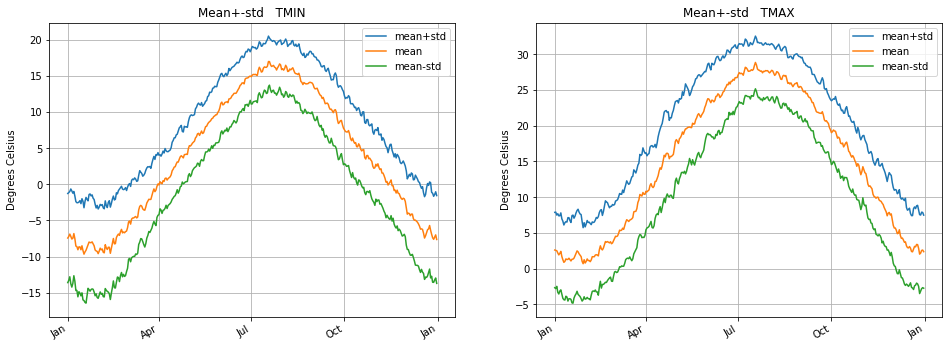

In [88]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

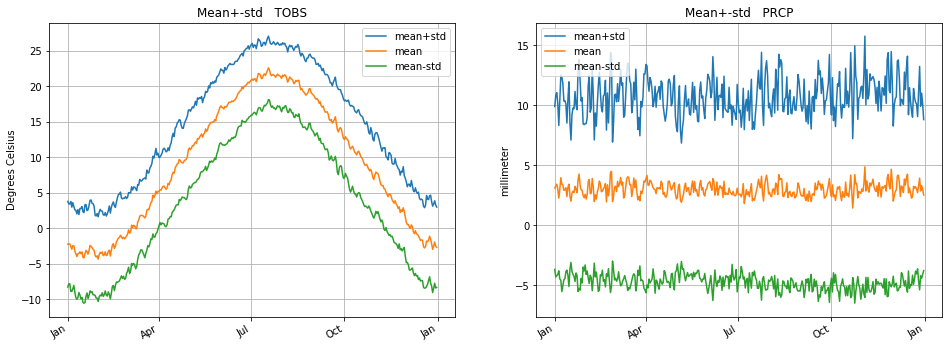

In [89]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

In [90]:
%mkdir r_figures

mkdir: r_figures: File exists


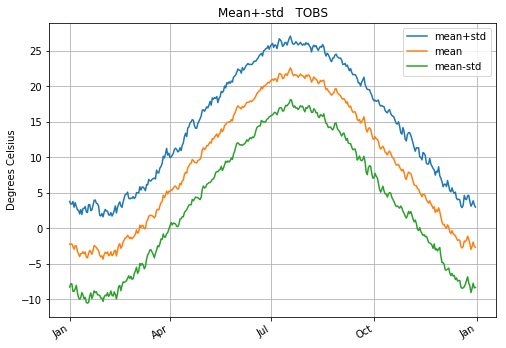

In [91]:
plot_single('TOBS',plot_mean_std,'r_figures/TOBS.png')

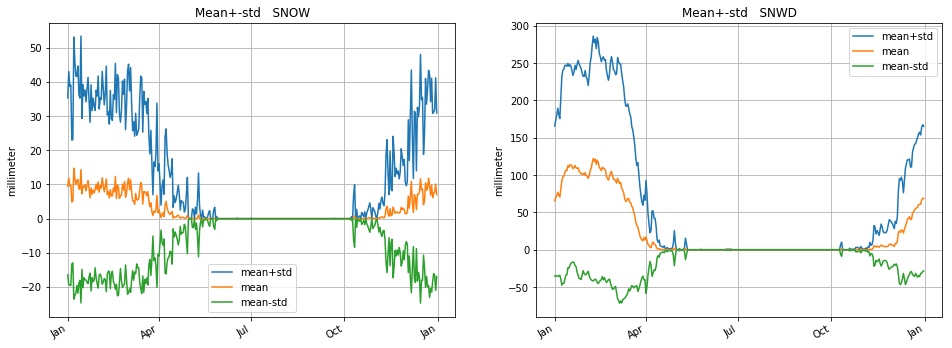

In [92]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

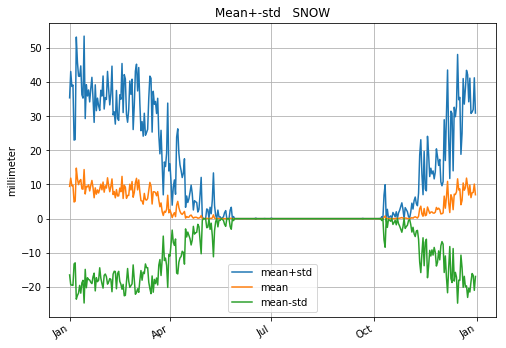

In [93]:
plot_single('SNOW',plot_mean_std,'r_figures/SNOW.png')

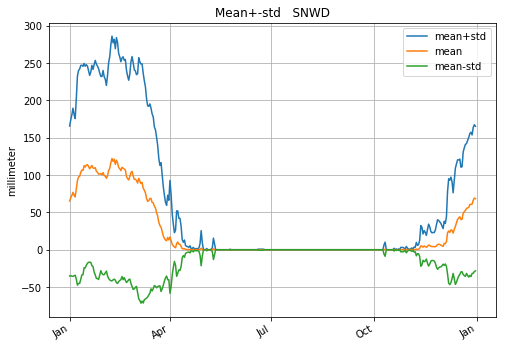

In [95]:
plot_single('SNWD',plot_mean_std,'r_figures/SNWD.png')

### plotting top 3 eigenvectors

In [13]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

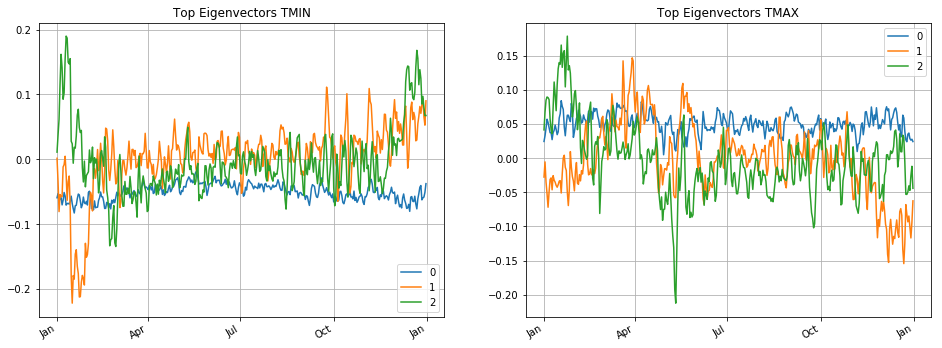

In [14]:
plot_pair(['TMIN','TMAX'],plot_eigen)

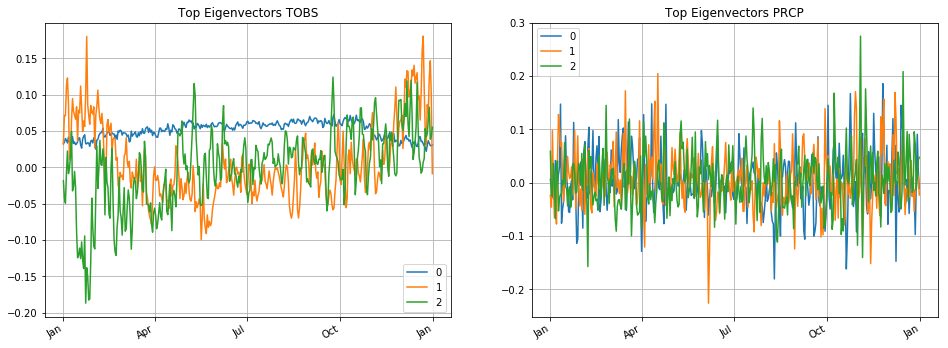

In [15]:
plot_pair(['TOBS','PRCP'],plot_eigen)

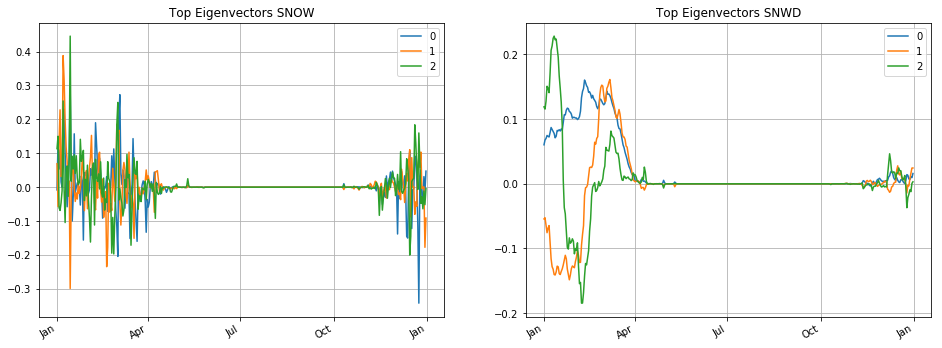

In [16]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [21]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    L=([0,]+list(cumsum(EV[:k])))/sum(EV)
    #print m,L
    plot(L)
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

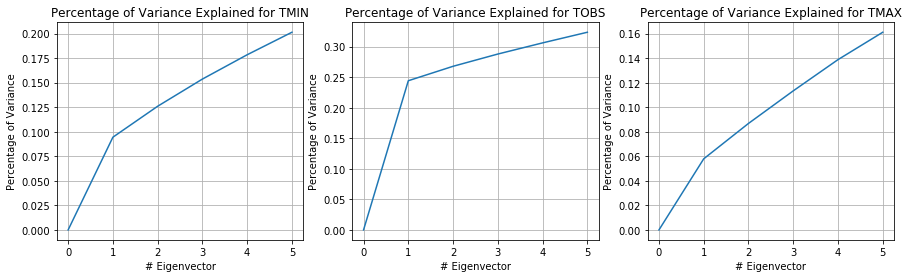

In [23]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1
f.savefig('r_figures/VarExplained1.png')

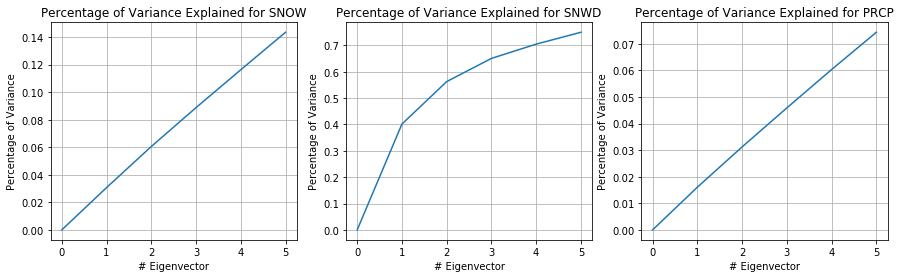

In [24]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 
f.savefig('r_figures/VarExplained2.png')

In [20]:
#sc.stop()